# Correlations and relationships between movements

In [60]:
"""
Imports
"""
import pandas as pd
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from one.api import ONE
import brainbox.behavior.wheel as wh
from scipy.stats import zscore
from scipy import stats
from scipy import signal

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'

os.chdir(functions_path)
from one_functions_generic import query_subjects_interest, subjects_interest_data, prepro, timeseries_PSTH
from video_functions import keypoint_speed, downsample, pupil_center, get_dlc_XYs, find_nearest, get_raw_and_smooth_position, get_pupil_diameter, pupil_center, nose_tip, tongue_tip
from design_functions import lick_rate, wheel_velocity, wheel_displacement, pupil_diam, cont_bin


In [2]:
one = ONE()

In [3]:
# Choose a session with good QC
data_path = '/home/ines/repositories/representation_learning_variability/Video/'
data_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Video/'

os.chdir(data_path)
pass_qc = pickle.load(open(data_path + "good_brainwide_sessions", "rb"))
example_session = 'd23a44ef-1402-4ed7-97f5-47e9a7a504d9'

## Correlation between pupil size and wheel movement

In [9]:
# Parameters
bin_size = 0.1  # seconds
video_type = 'left'

### Session-specific data

In [10]:
# Trials data
session_trials = one.load_object(example_session, obj='trials', namespace='ibl')
session_trials = prepro(session_trials.to_df())

# Wheel
wheel = one.load_object(example_session, 'wheel', collection='alf')
pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

# Pupil diameter
pupil_dia_raw, pupil_dia_smooth, _, _ = (
    get_raw_and_smooth_position(example_session, video_type, ephys=True, position_function=get_pupil_diameter))
pupil_t, XYs = get_dlc_XYs(example_session, view=video_type, likelihood_thresh=0.9)

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


In [56]:
session_length = list(session_trials['stimOff_times'][-1:])[0]
n_bins = int(np.floor(session_length/bin_size))
onsets = session_trials['stimOn_times']

# Initialize dataframe
wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=False)
wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)

pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

In [70]:
# Merge data
all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')

In [98]:
# Remove wheel disp (was used just to get onset times alignment with bins)
data_df = all_metrics.dropna().drop_duplicates()

# Bin data on both axes
bin_edges = [0, 2.5, 5, 7.5, 10, 12.5,  15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
bin_edges = [0, 5, 10, 15, 20, 25, 30, 35]
data_df['pupil_bin'] = pd.cut(data_df['pupil_diameter'], bins=bin_edges)

#data_df = data_df.groupby(['pupil_bin'])['avg_wheel_vel'].mean()
#data_df = data_df.reset_index(level=[0])

data_df['avg_wheel_vel'] = np.abs(data_df['avg_wheel_vel'])

Text(0, 0.5, 'Wheel velocity')

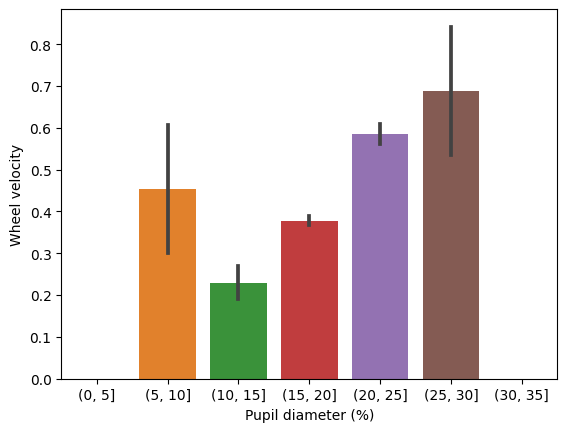

In [100]:
#sns.catplot(x='pupil_bin', y='avg_wheel_vel', data=data_df, kind="violin")  # 
sns.barplot(x='pupil_bin', y='avg_wheel_vel', data=data_df)  # 
plt.xlabel('Pupil diameter (%)')
plt.ylabel('Wheel velocity')

### Plot pupil diameter and wheel speed

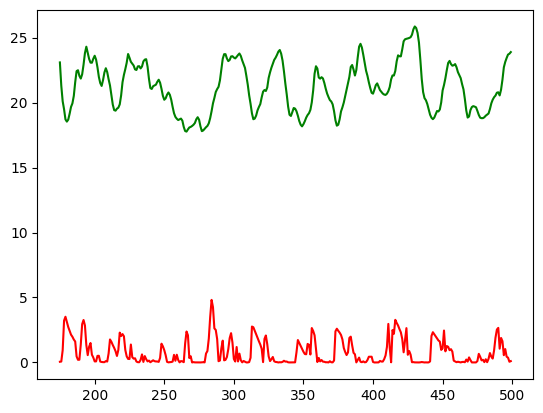

In [101]:
use_data = data_df.loc[data_df['Bin']<500]

plt.plot(use_data['Bin'], use_data['pupil_diameter'], color='green')
plt.plot(use_data['Bin'], np.abs(use_data['avg_wheel_vel']), color='red')


#sns.lineplot(x='Bin', y='pupil_diameter', data=use_data)

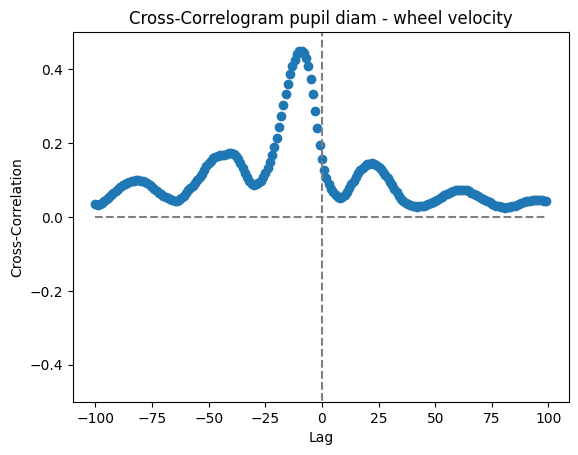

In [203]:
x = data_df['pupil_diameter']
y = data_df['avg_wheel_vel']

# Calculate the lag values corresponding to the cross-correlation
lags = np.arange(-100, 100)

# Compute the cross-correlation using np.correlate
cross_correlation = np.zeros(len(lags)) * np.nan
len_timeseries = len(x)
for l, lag in enumerate(lags):
    if lag < 0:
        x_chunk = np.array(x[-lag:])
        y_chunk = np.array(y[:lag])
    elif lag == 0:
        x_chunk = np.array(x)
        y_chunk = np.array(y)
    elif lag > 0:
        x_chunk = np.array(x[0:-lag])
        y_chunk = np.array(y[lag:])
    cross_correlation[l] = stats.pearsonr(x_chunk, y_chunk).statistic
    #np.sum(x_chunk * y[lag-lag:len(x_chunk)]) / ((len_timeseries-lag)* np.std(x_chunk) * np.std(y[lag-lag:len(x_chunk)]))

# Plot the cross-correlation
import matplotlib.pyplot as plt
plt.scatter(lags, cross_correlation)
plt.hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
plt.vlines(0, -1, 1, color='gray', linestyles='--')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlogram pupil diam - wheel velocity')
plt.ylim([-.5, .5])
plt.show()

In [ ]:

# Trials data
session_trials = one.load_object(example_session, obj='trials', namespace='ibl')
session_trials = session_trials.to_df()

# Licks
session_licks = get_lick_times(example_session, combine=False, video_type=video_type)

# Wheel
wheel = one.load_object(example_session, 'wheel', collection='alf')
pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position)

# Pupil diameter
pupil_dia_raw, pupil_dia_smooth, _, _ = (
    get_raw_and_smooth_position(example_session, video_type, ephys=True, position_function=get_pupil_diameter))
pupil_t, XYs = get_dlc_XYs(example_session, view=video_type, likelihood_thresh=0.9)

# Motion energy of whisker pad
me_times, motion_energy = get_ME(example_session, video_type)       
motion_energy = zscore(motion_energy, nan_policy='omit') 

# Nose velocity
nose_speeds = keypoint_speed(example_session, True, 'nose_tip', True)
nose_times = nose_speeds['left'][0][1:]
nose_speed_X = nose_speeds['left'][1]
nose_speed_Y = nose_speeds['left'][2]

# Right paw velocity
right_p_speeds = keypoint_speed(example_session, True, 'paw_r', True)
right_p_times = right_p_speeds['right'][0][1:]
right_p_speed_X = right_p_speeds['right'][1]
right_p_speed_Y = right_p_speeds['right'][2]

# Left paw velocity
left_p_speeds = keypoint_speed(example_session, True, 'paw_r', True)
left_p_times = left_p_speeds['left'][0][1:]
left_p_speed_X = left_p_speeds['left'][1]
left_p_speed_Y = left_p_speeds['left'][2]

# Pupil velocity
pupil_speeds = keypoint_speed(example_session, True, pupil_center, True)
pupil_times = pupil_speeds['left'][0][1:]
pupil_speed_X = pupil_speeds['left'][1]
pupil_speed_Y = pupil_speeds['left'][2]

In [ ]:
session_length = list(session_trials['stimOff_times'][-1:])[0]
n_bins = int(np.floor(session_length/bin_size))
onsets = session_trials['stimOn_times']

# Initialize dataframe

licking = lick_rate(bin_size, session_licks, session_trials)
wheel_vel = wheel_velocity(bin_size, wheel_times, pos, session_trials)
wheel_disp = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=False)
#wheel_disp_norm = wheel_displacement(wheel_times, pos, session_trials, bin_size, onset_subtraction=True)
pupil = pupil_diam(pupil_t, pupil_dia_smooth, session_trials, bin_size, onset_subtraction=True)
whisker_me = cont_bin(me_times, motion_energy, session_trials, bin_size)
nose_vel_X = cont_bin(nose_times, nose_speed_X, session_trials, bin_size)
nose_vel_Y = cont_bin(nose_times, nose_speed_Y, session_trials, bin_size)
right_vel_X = cont_bin(right_p_times, right_p_speed_X, session_trials, bin_size)
right_vel_Y = cont_bin(right_p_times, right_p_speed_Y, session_trials, bin_size)
left_vel_X = cont_bin(left_p_times, left_p_speed_X, session_trials, bin_size)
left_vel_Y = cont_bin(left_p_times, left_p_speed_Y, session_trials, bin_size)
pupil_vel_X = cont_bin(pupil_times, pupil_speed_X, session_trials, bin_size)
pupil_vel_Y = cont_bin(pupil_times, pupil_speed_Y, session_trials, bin_size)

In [ ]:
pupil = pupil.rename(columns={'pupil_final':'pupil_diameter'})

whisker_me = whisker_me.rename(columns={'Values':'whisker_me'})

nose_vel_X = nose_vel_X.rename(columns={'Values':'nose_speed_X'})
nose_vel_Y = nose_vel_Y.rename(columns={'Values':'nose_speed_Y'})

right_vel_X = right_vel_X.rename(columns={'Values':'r_paw_speed_X'})
right_vel_Y = right_vel_Y.rename(columns={'Values':'r_paw_speed_Y'})

left_vel_X = left_vel_X.rename(columns={'Values':'l_paw_speed_X'})
left_vel_Y = left_vel_Y.rename(columns={'Values':'l_paw_speed_Y'})

pupil_vel_X = pupil_vel_X.rename(columns={'Values':'pupil_speed_X'})
pupil_vel_Y = pupil_vel_Y.rename(columns={'Values':'pupil_speed_Y'})
#wheel_disp_norm = wheel_disp_norm.rename(columns={'wheel_final':'wheel_disp_norm'})

In [ ]:
all_metrics = wheel_vel[['Bin', 'avg_wheel_vel']].merge(licking[['Bin', 'Lick count']], on='Bin', how='outer')
all_metrics = all_metrics.merge(wheel_disp[['Bin', 'Onset times']], on='Bin', how='outer')
#all_metrics = all_metrics.merge(wheel_disp_norm[['Bin', 'wheel_disp_norm']], on='Bin', how='outer')
all_metrics = all_metrics.merge(pupil[['Bin', 'pupil_diameter']], on='Bin', how='outer')
all_metrics = all_metrics.merge(whisker_me[['Bin', 'whisker_me']], on='Bin', how='outer')
all_metrics = all_metrics.merge(nose_vel_X[['Bin', 'nose_speed_X']], on='Bin', how='outer')
all_metrics = all_metrics.merge(nose_vel_Y[['Bin', 'nose_speed_Y']], on='Bin', how='outer')

all_metrics = all_metrics.merge(right_vel_X[['Bin', 'r_paw_speed_X']], on='Bin', how='outer')
all_metrics = all_metrics.merge(right_vel_Y[['Bin', 'r_paw_speed_Y']], on='Bin', how='outer')

all_metrics = all_metrics.merge(left_vel_X[['Bin', 'l_paw_speed_X']], on='Bin', how='outer')
all_metrics = all_metrics.merge(left_vel_Y[['Bin', 'l_paw_speed_Y']], on='Bin', how='outer')

In [ ]:
all_metrics['Lick count'] = all_metrics['Lick count'].replace(np.NaN, 0)
all_metrics = all_metrics.dropna().drop_duplicates()